In [1]:
import sys

import numpy as np

sys.path.insert(1, "./src")

In [2]:
import pickle
from pathlib import Path
from collections import Counter

import yaml
from transformers import set_seed

from anonymization.gpt2_generation import GPT2GenerationAnonymization
from mask.util import convert_masked_docs_to_segments_set
from models.gpt2_model import PretrainedGPT2TextInfilling
from utils.infill_metrics import Statistics
from utils.log_reader import TensorBoardReader
from datasets.ner_dataset import get_ner_dataset
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
mask_config = yaml.load(open("configs/ngram_mask_config.yaml", 'r'), Loader=yaml.Loader)
roc_stories_data_config = yaml.load(open("configs/roc_stories_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Anonymization config initialisation
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config["model_version"] = 20

In [6]:
# Инициализация алгоритма генерации искусственных сущностей с помощью GPT2
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint, strict=False).to("cuda:0")

anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.2
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['ner_model.model.embeddings.word_embeddings.weight', 'ner_model.model.embeddings.position_embeddings.weight', 'ner_model.model.embeddings.token_type_embeddings.weight', 'ner_model.model.embeddings.LayerNorm.weight', 'ner_model.model.embeddings.LayerNorm.bias', 'ner_model.model.encoder.layer.0.attention.self.query.weight', 'ner_model.model.encoder.layer.0.attention.self.query.bias', 'ner_model.model.encoder.layer.0.attention.self.key.weight', 'ner_model.model.encoder.layer.0.attention.self.key.bias', 'ner_model.model.encoder.layer.0.attention.self.value.weight', 'ner_model.model.encoder.layer.0

In [7]:
def print_helpfull_statistics(infill_stats: Statistics):
    min_cer = min([min(x) for x in infill_stats.error_rates])
    mean_cer = sum([sum(x) for x in infill_stats.error_rates]) / sum([len(x) for x in infill_stats.error_rates])
    print(f"Средний показатель CER между изначальными текстами и ответами в примерах(macro_avg): {infill_stats.avg_cer:.3f}")
    print(f"Средний CER между изначальными текстами и ответами (micro_avg): {mean_cer:.3f}")
    print(f"Минимальный CER между изначальным текстом и ответом: {min_cer:.3f}")

    print("Число сэмплов с идеальными угадываниями:", len([x for x in infill_stats.error_rates if any(np.array(x) == 0.)]), 
          "/", len(infill_stats.error_rates))
    print("Число идеальных угадываний:", sum([np.sum(np.array(x) == 0.) for x in infill_stats.error_rates]), 
      "/", sum([len(x) for x in infill_stats.error_rates]))
    print("Статистика по угаданным типам данных:")
    guessed_categories = [np.array([cat for cat in categories if cat != infill_stats.other_label]) for categories in infill_stats.general_category_list]
    guessed_text = [np.array([infill_stats.source_text_list[i][j] for j, cat in enumerate(categories) if cat != infill_stats.other_label]) 
                    for i, categories in enumerate(infill_stats.general_category_list)]
    guessed_categories = sum([c[np.array(x) == 0.].tolist() for x, c in zip(infill_stats.error_rates, guessed_categories)], [])
    guessed_text = sum([t[np.array(x) == 0.].tolist() for x, t in zip(infill_stats.error_rates, guessed_text)], [])
    guessed_categories = Counter(guessed_categories)
    guessed_text = Counter(guessed_text)
    print(guessed_categories)
    print(guessed_text)

    print("Количество используемых лемм при анонимизации:", {k: len(v) for k, v in infill_stats.sub_label_lemmas.items()})
    print("Количество используемых лемм в изначальном наборе данных:", {k: len(v) for k, v in infill_stats.orig_label_lemmas.items()})
    print("Доля лемм, используемых из изначального набора данных:")
    print({k: len(v & infill_stats.orig_label_lemmas[k]) / len(v) for k, v in infill_stats.sub_label_lemmas.items()})

### Графики обучения модели для заполнения пропусков

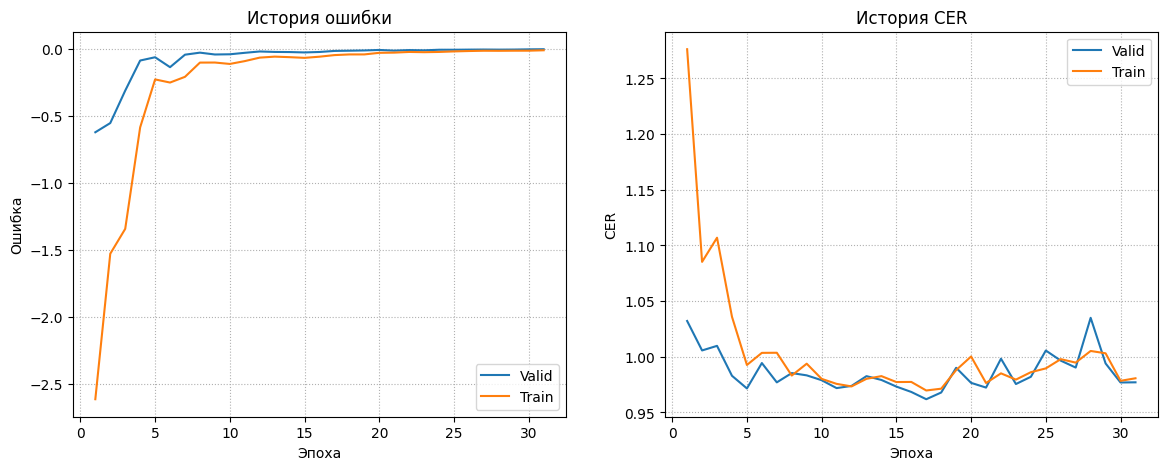

In [8]:
model_reader.plot_text_infill_tensorboard_graphics(13)

#### Проверка заполнения пропусков на случайным образом замаскированных текстах (roc stories)

In [9]:
path_to_data = roc_stories_data_config["validate_data_path"]
split = "valid"
if Path(path_to_data).suffix != '.pkl':
    path_to_data = str(Path(path_to_data).parent / Path(f'{Path(path_to_data).stem}_{split}.pkl'))
    
# категории сущностей в формате [список категорий отрезков в документе, ...]; исходный текст в формате [список отрезков в документе, ...]
with open(path_to_data, 'rb') as f:
    # [(текст документа, список наборов масок для него: [[(тип, сдвиг, длина), ...], ...]), ...]
    infill_dataset = pickle.load(f)
    _, categories_list, source_texts = convert_masked_docs_to_segments_set(infill_dataset)

In [10]:
infill_stats = Statistics(anonymization, categories_list[:3000], categories_list[:3000], source_texts[:3000], is_uncased=True)

Start data tokenization


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

In [11]:
indexes = infill_stats.random_examples_indexes(30)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 1149 _____
| Labels:           | O                                         | ID          | O                                           | DATE         | O            | LOCATION  | O                             | DATE             | O                    | LOCATION |
| Source text:      | Kelly hasn't left her apartment in years. | I went      | up to her place today to say hello. I could | tell she was | reluctant to | let me in | . We talked for a while about | how she's doing. | Kelly is agoraphobic | .        |
| Substituted text: | Kelly hasn't left her apartment in years. | nora, kelli | up to her place today to say hello. I could | nora, ida    | reluctant to | july 20th | . We talked for a while about | july 20th        | Kelly is agoraphobic | ,        |
| CER               |                                           | 1.500       |                                             | 0.917        |              | 1.000     |                               | 0.938            

#### Проверка заполнения пропусков в примерах с личной информацией (i2b2_2014)

##### Тренировочная выборка

In [12]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [13]:
path = str(Path(i2b2_2014_data_config["train_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [14]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

In [15]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 558 _____
| Labels:           | O            | DATE       | O | DATE              | O | NAME            | O      | LOCATION              | O | LOCATION | O | LOCATION | O | LOCATION | O   | NAME          | O    | ID          | O        | NAME    | O | NAME          | O                                                                                                                                                 | LOCATION   | O                                                                                                                                                                 |
| Source text:      | record date: | 2083-07-18 |   | july 18, 2083     |   | vincent ventura | , m.d. | 4971 edmatteric drive |   | cheney   | , | tx       |   | 37523    | re: | peggy tinsley | mr # | 236-67-03-3 | dear dr. | ventura | : | peggy tinsley | was seen in the renal clinic today.  this patient with end stage renal disease secondary to diabetes was initiated on hemodialysis 2 wee

In [16]:
(record_ids, col_j), cer = infill_stats.find_closest_substitutions(5)
infill_stats.print_examples_by_indexes(record_ids.tolist(), max_example_len=500, start_other_len=100)

_____ Record 397 _____
| Labels:           | O            | DATE       | O          | LOCATION               | O | NAME          | O    | LOCATION          | O          | LOCATION               | O           | LOCATION | O | LOCATION | O | LOCATION | O    | NAME       | O                                                 | NAME       | O                                                                                                                                                                                                                         | DATE       | O                        |
| Source text:      | record date: | 2159-05-12 | cardiology | wisner family practice |   | floyd r shaw  | m.d. | mariners hospital | internists | 6293 brookside terrace | , suite 626 | grayling | , | me       |   | 78726    | dear | fitzgerald | :      i had the pleasure of seeing your patient, | haden doty | , in consultation today regarding his peripheral arterial disease and generalized vascular 

In [17]:
print_helpfull_statistics(infill_stats)

Средний показатель CER между изначальными текстами и ответами в примерах(macro_avg): 1.092
Средний CER между изначальными текстами и ответами (micro_avg): 1.084
Минимальный CER между изначальным текстом и ответом: 0.000
Число сэмплов с идеальными угадываниями: 100 / 790
Число идеальных угадываний: 267 / 17405
Статистика по угаданным типам данных:
Counter({'DATE': 193, 'AGE': 28, 'LOCATION': 24, 'NAME': 19, 'PROFESSION': 3})
Counter({'07/02/88': 26, '08/29/62': 25, '06/12/2072': 25, '07/05/77': 25, 'nora': 16, '02/02/79': 13, '2081': 9, 'january': 8, '02/17/2076': 8, '2097/04/30': 8, '73': 6, '11/08/2080': 6, '01/28/2081': 5, '2080': 4, '72': 4, 'june': 4, '70': 4, 'wfp': 4, 'educare-fargo': 3, 'july': 3, 'october': 3, '2090': 3, 'michigan': 3, 'maine': 2, '60': 2, 'manager': 2, '80': 2, '59': 2, 'educare-pullman': 2, 'mary': 2, '01/20/79': 2, 'september': 1, 'spring': 1, '2082': 1, '2070': 1, '20s': 1, 'nichols': 1, 'nj': 1, '67': 1, 'august': 1, '62': 1, 'paralegal': 1, 'english': 1, 

##### Валидационная выборка

In [18]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], device='cpu', **i2b2_2014_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [19]:
path = str(Path(i2b2_2014_data_config["validate_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [20]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

In [21]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 284 _____
| Labels:           | O            | DATE       | O                          | NAME             | O   | ID        | O                  | DATE             | O    | NAME       | O | AGE   | O                                                                                                                                                                                                                                                                                                                                      |
| Source text:      | record date: | 2094-10-29 | micu intern admission note | faulkner, yandel | mr# | 5075561   | date of admission: | october 28, 2094 | pcp: | lord, dana | id/cc:	gi bleed    hpi:   | 69    | yo man w/ h/o aaa, pvd, cad, af w/ tracheostomy and g-tube in place, on coumadin for pvd, hit +,  and dvt w/ inr yesterday of 5.3.  noticed black stools x 1 day, and blood suctioned form g-tube.  came to ed and while in ed waiting for a room had an

In [22]:
(record_ids, col_j), cer = infill_stats.find_closest_substitutions(5)
infill_stats.print_examples_by_indexes(record_ids.tolist(), max_example_len=500, start_other_len=100)

_____ Record 199 _____
| Labels:           | O            | DATE       | O | LOCATION           | O | NAME          | O | ID        | O | DATE     | O   | NAME   | O    | AGE   | O                                                                                                                                                                 | LOCATION | O                                                                                                           |
| Source text:      | record date: | 2084-01-21 |   | orlando regional   |   | xavier, fred  |   | 65856594  |   | 1-21-84  | mr. | xavier | is a | 71    | -year-old male coming in for the first time for  evaluation and follow up for health maintenance.  he comes in without  major complaints.  he is a gentleman from | eritrea  | who is now retired.   he is a very active person.  he is able to walk 2-3 kilometers without any  dyspnea o |
| Substituted text: | record date: | 2081-12-12 |   | michigan, brooklyn |   | jones,roberta | 

In [23]:
print_helpfull_statistics(infill_stats)

Средний показатель CER между изначальными текстами и ответами в примерах(macro_avg): 1.106
Средний CER между изначальными текстами и ответами (micro_avg): 1.108
Минимальный CER между изначальным текстом и ответом: 0.000
Число сэмплов с идеальными угадываниями: 22 / 514
Число идеальных угадываний: 24 / 11462
Статистика по угаданным типам данных:
Counter({'AGE': 15, 'DATE': 8, 'NAME': 1})
Counter({'73': 4, '61': 2, '2082': 1, '12/2097': 1, '80': 1, '72': 1, '2081': 1, '2090': 1, 'xavier': 1, '59': 1, '2094': 1, '74': 1, '70s': 1, '2060s': 1, '2089': 1, '70': 1, "60's": 1, 'july': 1, '66': 1, '54': 1})
Количество используемых лемм при анонимизации: {'DATE': 1180, 'NAME': 580, 'ID': 389, 'LOCATION': 506, 'AGE': 135, 'PROFESSION': 106, 'CONTACT': 155}
Количество используемых лемм в изначальном наборе данных: {'DATE': 2367, 'NAME': 1690, 'ID': 432, 'LOCATION': 1093, 'AGE': 82, 'PROFESSION': 152, 'CONTACT': 226}
Доля лемм, используемых из изначального набора данных:
{'DATE': 0.107627118644067

#### Проверка заполнения пропусков в примерах с личной информацией (i2b2_2006)

##### Тренировочная выборка

In [24]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2006_data_config["train_data_path"], device='cpu', **i2b2_2006_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


In [25]:
path = str(Path(i2b2_2006_data_config["train_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [26]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

In [27]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 284 _____
| Labels:           | ID        | LOCATION  | ID        | ID        | DATE  | O                                                                       | DATE  | O                                      | DATE  | O                                          | NAME      | ID              | O      | LOCATION | O                                    | DATE  | O                                                                                                              | NAME                    | O                                                                                         |
| Source text:      | 639561722 | eh        | 08107672  | 6574945   | 2/20  | /2006 12:00:00 am chf , polysubstance abuse , copd dis admission date : | 02/20 | /2006 report status : discharge date : | 02/22 | /2006 ****** final discharge orders ****** | yaw , tao | 831-83-99-8 e47 | room : | 05w-814  | service : car discharge patient on : | 02/22 | /06 at 02:00 pm contingent upon not applicab

In [28]:
(record_ids, col_j), cer = infill_stats.find_closest_substitutions(5)
infill_stats.print_examples_by_indexes(record_ids.tolist(), max_example_len=500, start_other_len=100)

_____ Record 188 _____
| Labels:           | ID        | LOCATION | ID      | ID         | ID      | DATE  | O                                                                                          | DATE  | O                    | DATE  | O                     | NAME       | O                                                          | LOCATION                   | O  | LOCATION         | O                                                                                | NAME  | O                                                                                                                |
| Source text:      | 342570083 | puomc    | 7625956 | 05527/8m03 | 529937  | 4/9   | /1994 12:00:00 am discharge summary unsigned dis report status : unsigned admission date : | 04-09 | -94 discharge date : | 05-26 | -94 chief complaint : | cean leach | is a 38 year old male who is admitted in transfer from the | morehegron valley hospital | in | ville , virginia | for further evaluation and manage

In [29]:
print_helpfull_statistics(infill_stats)

Средний показатель CER между изначальными текстами и ответами в примерах(macro_avg): 1.336
Средний CER между изначальными текстами и ответами (micro_avg): 1.327
Минимальный CER между изначальным текстом и ответом: 0.000
Число сэмплов с идеальными угадываниями: 10 / 669
Число идеальных угадываний: 10 / 14253
Статистика по угаданным типам данных:
Counter({'DATE': 10})
Counter({'october': 5, 'january': 3, '1/22': 1, 'september': 1})
Количество используемых лемм при анонимизации: {'ID': 566, 'LOCATION': 356, 'DATE': 1088, 'NAME': 502, 'CONTACT': 98, 'AGE': 10}
Количество используемых лемм в изначальном наборе данных: {'ID': 3676, 'LOCATION': 844, 'DATE': 977, 'NAME': 2764, 'CONTACT': 128, 'AGE': 12}
Доля лемм, используемых из изначального набора данных:
{'ID': 0.0017667844522968198, 'LOCATION': 0.06179775280898876, 'DATE': 0.034926470588235295, 'NAME': 0.07171314741035857, 'CONTACT': 0.0, 'AGE': 0.0}


##### Валидационная выборка

In [31]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [32]:
path = str(Path(i2b2_2014_data_config["validate_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [33]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

In [34]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 94 _____
| Labels:           | O            | DATE       | O   | LOCATION         | O | NAME            | O | LOCATION  | O | LOCATION | O | LOCATION | O | ID       | O        | DATE       | O | NAME         | O      | LOCATION                | O | LOCATION          | O | LOCATION   | O | LOCATION | O | LOCATION | O        | NAME        | O            | NAME         | O                                                         | DATE      | O                                                                                                                                         |
| Source text:      | record date: | 2089-12-07 | ent | 72 chablis court |   | upshur, irene   |   | argentine | , | nv       |   | 57431    |   | 78197017 | -------- | 12/07/2089 |   | steven short | , m.d. | evans memorial hospital |   | 745 morgan street |   | sag harbor | , | nv       |   | 62945    | dear dr. | short       | :  i did see | irene upshur | for a followup today.  as you know, i did 

In [35]:
(record_ids, col_j), cer = infill_stats.find_closest_substitutions(5)
infill_stats.print_examples_by_indexes(record_ids.tolist(), max_example_len=500, start_other_len=100)

_____ Record 199 _____
| Labels:           | O            | DATE       | O | LOCATION           | O | NAME          | O | ID        | O | DATE     | O   | NAME   | O    | AGE   | O                                                                                                                                                                 | LOCATION | O                                                                                                           |
| Source text:      | record date: | 2084-01-21 |   | orlando regional   |   | xavier, fred  |   | 65856594  |   | 1-21-84  | mr. | xavier | is a | 71    | -year-old male coming in for the first time for  evaluation and follow up for health maintenance.  he comes in without  major complaints.  he is a gentleman from | eritrea  | who is now retired.   he is a very active person.  he is able to walk 2-3 kilometers without any  dyspnea o |
| Substituted text: | record date: | 2081-12-12 |   | michigan, brooklyn |   | jones,roberta | 

In [36]:
print_helpfull_statistics(infill_stats)

Средний показатель CER между изначальными текстами и ответами в примерах(macro_avg): 1.106
Средний CER между изначальными текстами и ответами (micro_avg): 1.108
Минимальный CER между изначальным текстом и ответом: 0.000
Число сэмплов с идеальными угадываниями: 22 / 514
Число идеальных угадываний: 24 / 11462
Статистика по угаданным типам данных:
Counter({'AGE': 15, 'DATE': 8, 'NAME': 1})
Counter({'73': 4, '61': 2, '2082': 1, '12/2097': 1, '80': 1, '72': 1, '2081': 1, '2090': 1, 'xavier': 1, '59': 1, '2094': 1, '74': 1, '70s': 1, '2060s': 1, '2089': 1, '70': 1, "60's": 1, 'july': 1, '66': 1, '54': 1})
Количество используемых лемм при анонимизации: {'DATE': 1180, 'NAME': 580, 'ID': 389, 'LOCATION': 506, 'AGE': 135, 'PROFESSION': 106, 'CONTACT': 155}
Количество используемых лемм в изначальном наборе данных: {'DATE': 2367, 'NAME': 1690, 'ID': 432, 'LOCATION': 1093, 'AGE': 82, 'PROFESSION': 152, 'CONTACT': 226}
Доля лемм, используемых из изначального набора данных:
{'DATE': 0.107627118644067